In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [1]:
import csv
import pandas as pd
from datetime import date,datetime
import io
import gcsfs
import os
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from datetime import datetime, timedelta
from prophet import Prophet
import numpy as np
import itertools

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use("fivethirtyeight")

In [5]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/cloud/integration-gcp-c828c815-6c5a918e4371.json'
bqclient = bigquery.Client()


In [6]:
query_string = """
SELECT
checkpoint,count(distinct player_id) as count_players
FROM `vxp-looker-8c0a3516.PW_staging.player_checkpoint_live`
where VXP_client_id=1 
group by checkpoint
"""

PL_events= (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

In [7]:
PL_events.count()

checkpoint       193
count_players    193
dtype: int64

In [8]:
PL_events.tail()

,checkpoint,count_players
188,2021-05-21,60157
189,2021-05-16,55652
190,2021-05-11,42912
191,2021-05-25,68162
192,2021-11-09,385


In [9]:
PL_events["date"]=pd.to_datetime(PL_events['checkpoint'])
PL_events=PL_events.set_index('date').sort_index()


In [10]:
PL_events=PL_events[:-1]

<AxesSubplot:xlabel='date'>

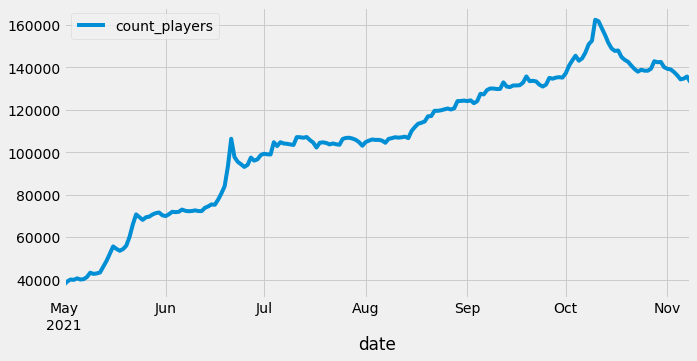

In [11]:
fig,ax=plt.subplots(1,figsize=(10,5))

PL_events.plot(ax=ax)


## Prophet Modeling

In [12]:
series=PL_events.reset_index()[['date','count_players']]
series.columns=['ds','y']

In [13]:
m1=Prophet()
m1.fit(series)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
m1=Prophet()
m1.fit(series)
future=m1.make_future_dataframe(periods=30)
forecast=m1.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
forecast[len(series):][['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
192,2021-11-09,143018.357327,136962.248463,149412.407452
193,2021-11-10,142525.435538,136562.342313,148749.967955
194,2021-11-11,142190.232076,136513.293872,147774.262549
195,2021-11-12,141877.660783,135641.855207,147818.856025
196,2021-11-13,142018.867210,135339.089960,148565.129266


In [16]:
results=forecast[len(series):][['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')

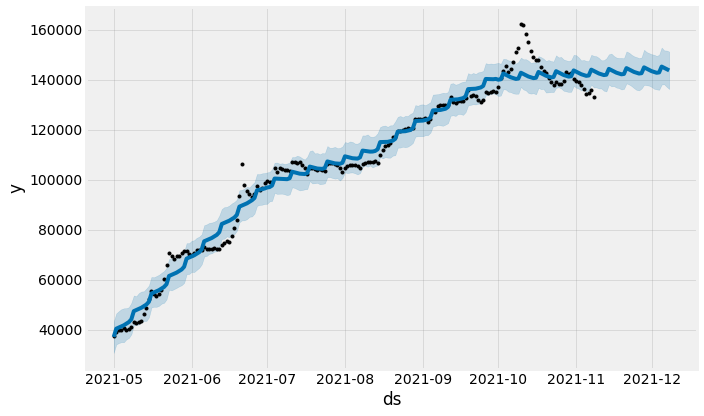

In [17]:
m1.plot(forecast)
plt.show()

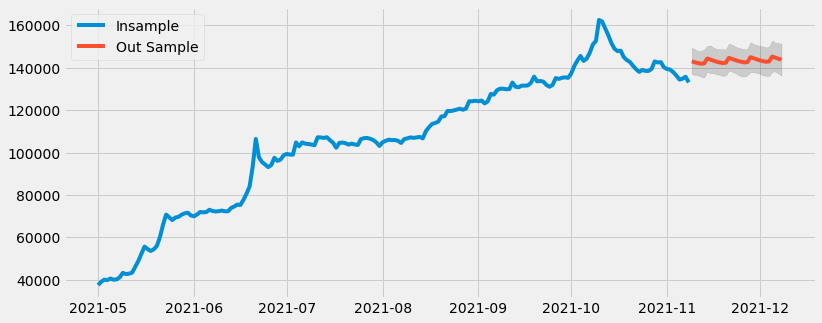

In [18]:
plt.figure(figsize=(12,5))
plt.plot(PL_events['count_players'],label="Insample")

plt.plot(results['yhat'],label='Out Sample')
# predictions=pd.Series(predictions,index=test.index)
# lower_series=pd.Series(ci_lower,index=test.index)
# upper_series=pd.Series(ci_upper,index=test.index)
# plt.plot(predictions,color='green',label='predicted')
plt.fill_between(results.index,results['yhat_lower'],results['yhat_upper'],color='k',alpha=0.15)
plt.legend()
plt.show()

## Prophet Hyperparameter tuning

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.



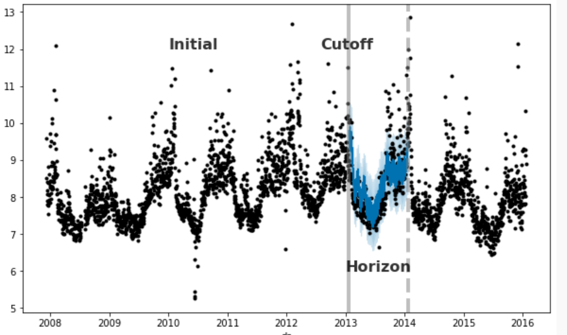

In [19]:
from prophet.diagnostics import cross_validation


In [20]:
print(len(series))
print(series['ds'].min())
print(series['ds'].max())

192
2021-05-01 00:00:00
2021-11-08 00:00:00


In [83]:
print(series.iloc[90])

ds    2021-07-30 00:00:00
y                  104764
Name: 90, dtype: object


<b>So What happens here is that Prophet starts from the end</b> <br>
<UL>

<LI>Substracts last date by horizon , (This will be the last cut-off) </LI>
<LI>Proceeds backwards to find other cut-offs (if no period is specified) cut-off will be apart by 0.5 * horizon </LI> 
<LI>This makes the initial training just optional as if no specified , will be 3 * horizon </LI>

In [21]:
#cross_validation(m1, initial='50 days',period='30 days', horizon = '30 days')
df_cv = cross_validation(m1, horizon = '30 days')
df_cv.head()


INFO:prophet:Making 5 forecasts with cutoffs between 2021-08-10 00:00:00 and 2021-10-09 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-08-11,106848.533824,101783.271441,111843.575918,106924,2021-08-10
1,2021-08-12,106669.248140,101832.692118,111377.184822,107105,2021-08-10
2,2021-08-13,106486.749102,101215.789472,111490.896631,107392,2021-08-10
3,2021-08-14,106715.610120,101677.014953,111463.924348,106694,2021-08-10
4,2021-08-15,109157.877787,104516.869112,114221.631469,110062,2021-08-10


In [22]:
df_cv['cutoff'].value_counts()


2021-08-10    30
2021-08-25    30
2021-09-09    30
2021-09-24    30
2021-10-09    30
Name: cutoff, dtype: int64

In [23]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
145,2021-11-04,160562.917300,155216.168364,166047.880869,136326,2021-10-09
146,2021-11-05,161003.090967,155418.450189,166559.351978,134412,2021-10-09
147,2021-11-06,161785.371287,156422.040691,167266.687380,134787,2021-10-09
148,2021-11-07,164414.634838,158729.947339,169932.115669,135738,2021-10-09
149,2021-11-08,164647.126047,158952.888010,170257.850104,133056,2021-10-09


<b>Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots

In [24]:
len(df_cv)

150

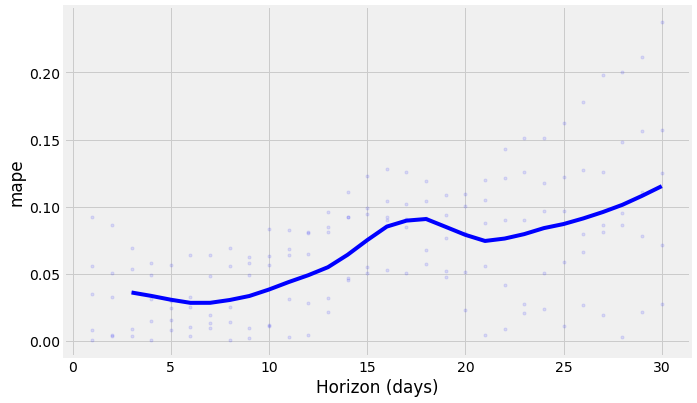

In [25]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


<b>The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was) <br> <br> These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

In [35]:
from prophet.diagnostics import performance_metrics
#Rolling window takes values ranging from 0.... to 1 (100%)
df_p = performance_metrics(df_cv,rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,1.649676e+08,12843.972586,10909.981338,0.082226,0.081037,0.082056,0.788889


In [34]:
df_p['mape'].mean()

0.08222629868323535

#### Using Prophet cross validation to tune two parameters

In [27]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(series)  # Fit model with given params
    df_cv = cross_validation(m, initial='90 days', period='30 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-08-10 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000014C7033F070>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2021-08-10 00:00:00 and 2021-10-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000014C703051F0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_s

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  17508.657798
1                     0.001                     0.10  17660.039096
2                     0.001                     1.00  17683.621606
3                     0.001                    10.00  17898.737877
4                     0.010                     0.01  10590.797842
5                     0.010                     0.10  10751.021990
6                     0.010                     1.00  10522.276024
7                     0.010                    10.00  10584.071341
8                     0.100                     0.01  13001.941132
9                     0.100                     0.10  13071.237931
10                    0.100                     1.00  13149.273156
11                    0.100                    10.00  13097.946320
12                    0.500                     0.01  12815.780297
13                    0.500                     0.10  12861.22

In [28]:
tuning_results.iloc[6]['rmse']

10522.276023581617

In [29]:
# Python
best_params = all_params[np.argmin(rmses)]
best_rmse=tuning_results.iloc[np.argmin(rmses)]['rmse']
print("Best Params are ",best_params)
print("Best RMSE is ",best_rmse)

Best Params are  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}
Best RMSE is  10522.276023581617


In [30]:
m1=Prophet(changepoint_prior_scale= best_params['changepoint_prior_scale'], seasonality_prior_scale=  best_params['seasonality_prior_scale'])
m1.fit(series)
future=m1.make_future_dataframe(periods=30)
forecast=m1.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
results=forecast[len(series):][['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')

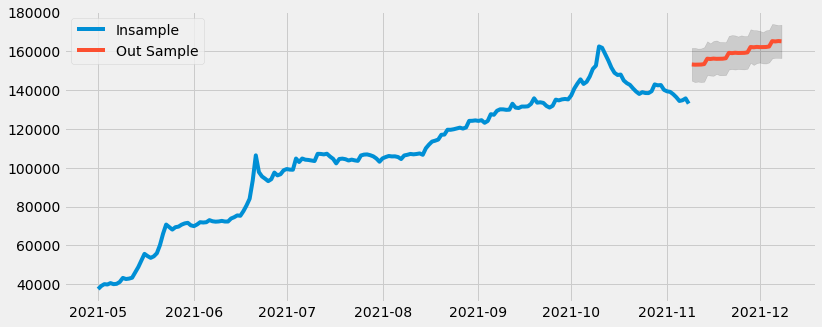

In [168]:
plt.figure(figsize=(12,5))
plt.plot(PL_events['count_players'],label="Insample")

plt.plot(results['yhat'],label='Out Sample')
# predictions=pd.Series(predictions,index=test.index)
# lower_series=pd.Series(ci_lower,index=test.index)
# upper_series=pd.Series(ci_upper,index=test.index)
# plt.plot(predictions,color='green',label='predicted')
plt.fill_between(results.index,results['yhat_lower'],results['yhat_upper'],color='k',alpha=0.15)
plt.legend()
plt.show()

In [36]:
results.reset_index()

,ds,yhat,yhat_lower,yhat_upper
0,2021-11-09,143018.357327,136962.248463,149412.407452
1,2021-11-10,142525.435538,136562.342313,148749.967955
2,2021-11-11,142190.232076,136513.293872,147774.262549
3,2021-11-12,141877.660783,135641.855207,147818.856025
4,2021-11-13,142018.867210,135339.089960,148565.129266
5,2021-11-14,144355.917098,138124.183241,150168.978305
6,2021-11-15,143838.384902,137371.380525,150466.422570
7,2021-11-16,143325.223687,137476.106866,149509.598483
8,2021-11-17,142832.301898,136902.538818,148869.382166
9,2021-11-18,142497.098436,136674.203370,148714.382446


In [38]:
results.to_csv("predictions.csv")

# Arima

In [37]:
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
def forecast_accuracy(forecast, actual):
    '''This function Takes forecasted and actual series and returns the RMSE error
    The inputs can be lists , series '''
    rmse=np.mean((forecast - actual)**2)**.5 
    
    return rmse

In [39]:
size=len(PL_events)
train=PL_events['count_players'][:round(size*0.6)]
test=PL_events['count_players'][round(size*0.6):]

##### Using Auto Arima 

In [48]:
arima_model=auto_arima(train,start_p=0,d=None,start_q=0,
                      max_p=8,max_d=2,max_q=8,
                       start_Q=0,max_Q=8,
                       start_P=0,max_P=8,m=7, max_D=4,D=None,
                       seasonal=True,supress_warnings=True,n_fits=50,out_of_sample_size=90 )

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1042.913
Date:                Sun, 28 Nov 2021   AIC                           2089.825
Time:                        20:58:00   BIC                           2095.298
Sample:                             0   HQIC                          2092.046
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    730.1121    238.348      3.063      0.002     262.958    1197.266
sigma2      5.195e+06   3.21e+05     16.185      0.000    4.57e+06    5.82e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.47   Jarque-Bera (JB):               474.99
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.50
Prob(H) (two-sided):                  0.08   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_model=auto_arima(train,start_p=0,d=None,start_q=0,
                      max_p=8,max_d=2,max_q=8,
                       start_Q=0,max_Q=8,
                       start_P=0,max_P=8,m=7, max_D=4,D=None,
                       seasonal=True,supress_warnings=True,n_fits=50,out_of_sample_size=90 )

arima_model.summary()

In [555]:
train

date
2021-05-01     37535
2021-05-02     39098
2021-05-03     40057
2021-05-04     39882
2021-05-05     40592
               ...  
2021-08-19    114539
2021-08-20    116991
2021-08-21    117112
2021-08-22    119590
2021-08-23    119567
Name: count_players, Length: 115, dtype: int64

In [558]:
arima_model=auto_arima(train.append(test),start_p=0,d=None,start_q=0,
                      max_p=8,max_d=2,max_q=8,
                       start_Q=0,max_Q=8,
                       start_P=0,max_P=8,m=7, max_D=4,D=None,
                       seasonal=True,supress_warnings=True,n_fits=50,out_of_sample_size=90 )

In [560]:
arima_model.order

(1, 1, 0)

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
def rolling_forecast_arima_final(train,test,order=(0,1,0),seasonal_order=None,window="sliding",forecast_steps=1,plotting=False):    
    history=train
    predictions=[]
    ci_lower=[]
    ci_upper=[]
    for t in range(0,len(test),forecast_steps):
        if forecast_steps > len(test)-t:
            forecast_steps=len(test)-t
        
        model=sm.tsa.statespace.SARIMAX(history,order=order,seasonal_order=seasonal_order,trend='c')
        model_ARIMA = model.fit()
        
        fc_list=list(model_ARIMA.get_forecast(steps=forecast_steps).predicted_mean.values)
        lower_list=        list(model_ARIMA.get_forecast(steps=forecast_steps,alpha=0.05).conf_int().iloc[:,0].values)
        upper_list=       list(model_ARIMA.get_forecast(steps=forecast_steps,alpha=0.05).conf_int().iloc[:,0].values)
        
        ci_lower=ci_lower + lower_list
        ci_upper=ci_upper + upper_list

        predictions=predictions + fc_list
        obs=test.loc[test.index[t:t+forecast_steps]]
        history=history.append(obs)
        if window=="sliding":
            history=history[forecast_steps:]
        
    if plotting==True:
        plt.figure(figsize=(12,5))
        plt.plot(train,label="Training")
        plt.plot(test,label='original test')
        predictions=pd.Series(predictions,index=test.index)
        lower_series=pd.Series(ci_lower,index=test.index)
        upper_series=pd.Series(ci_upper,index=test.index)
        plt.plot(predictions,color='green',label='predicted')
        plt.fill_between(lower_series.index,lower_series,upper_series,color='k',alpha=0.15)
        plt.legend()
        plt.show()
    
    rmse=forecast_accuracy(predictions,test.values)
    
    return model_ARIMA,predictions,rmse


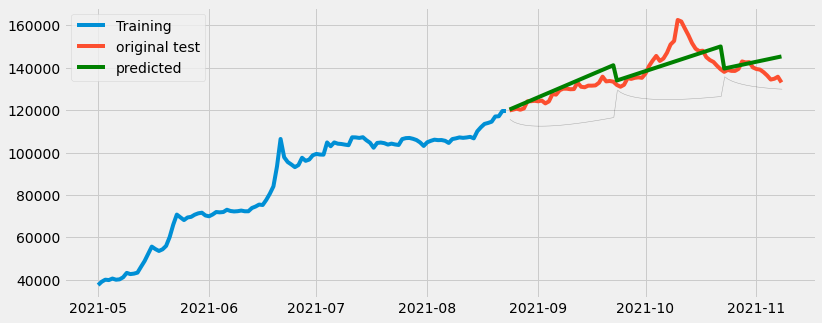

5760.591187133479


In [73]:
model,predictions,rmse_auto=rolling_forecast_arima_final(train,test,order=(0,1,0),seasonal_order=None,window="sliding",forecast_steps=30,plotting=True)
print(rmse_auto)

##### Using Manual hyper parameter tuning to see if results will be different

In [75]:
def evaluate_models(train,test,p_values,d_values,q_values,P_values,D_values,Q_values,forecast_steps=30,m=7):
    best_score,best_cfg=float("inf"),None    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:                
                            order=(p,d,q) 
                            seasonal_order=(P,D,Q,m)
                            print(order)
                            print(seasonal_order)
                            try :
                                model_ARIMA,predictions,rmse=rolling_forecast_arima_final(train,test,order=order,seasonal_order=seasonal_order,window="sliding",forecast_steps=forecast_steps,plotting=False)
                                if rmse < best_score:
                                    best_score,best_cfg=rmse,(order,seasonal_order)
                            except Exception:
                                print(Exception)
                                continue
    print(best_score)
    print(best_cfg)

In [76]:
evaluate_models(train,test,[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],forecast_steps=30,m=7)

(0, 0, 0)
(0, 0, 0, 7)
(0, 0, 0)
(0, 0, 1, 7)
(0, 0, 0)
(0, 1, 0, 7)
(0, 0, 0)
(0, 1, 1, 7)
(0, 0, 0)
(1, 0, 0, 7)
(0, 0, 0)
(1, 0, 1, 7)
(0, 0, 0)
(1, 1, 0, 7)
(0, 0, 0)
(1, 1, 1, 7)
(0, 0, 1)
(0, 0, 0, 7)
(0, 0, 1)
(0, 0, 1, 7)
(0, 0, 1)
(0, 1, 0, 7)
(0, 0, 1)
(0, 1, 1, 7)
(0, 0, 1)
(1, 0, 0, 7)
(0, 0, 1)
(1, 0, 1, 7)
(0, 0, 1)
(1, 1, 0, 7)
(0, 0, 1)
(1, 1, 1, 7)
(0, 1, 0)
(0, 0, 0, 7)
(0, 1, 0)
(0, 0, 1, 7)
(0, 1, 0)
(0, 1, 0, 7)
(0, 1, 0)
(0, 1, 1, 7)
(0, 1, 0)
(1, 0, 0, 7)
(0, 1, 0)
(1, 0, 1, 7)
(0, 1, 0)
(1, 1, 0, 7)
(0, 1, 0)
(1, 1, 1, 7)
(0, 1, 1)
(0, 0, 0, 7)
(0, 1, 1)
(0, 0, 1, 7)
(0, 1, 1)
(0, 1, 0, 7)
(0, 1, 1)
(0, 1, 1, 7)
(0, 1, 1)
(1, 0, 0, 7)
(0, 1, 1)
(1, 0, 1, 7)
(0, 1, 1)
(1, 1, 0, 7)
(0, 1, 1)
(1, 1, 1, 7)
(1, 0, 0)
(0, 0, 0, 7)
(1, 0, 0)
(0, 0, 1, 7)
(1, 0, 0)
(0, 1, 0, 7)
(1, 0, 0)
(0, 1, 1, 7)
(1, 0, 0)
(1, 0, 0, 7)
(1, 0, 0)
(1, 0, 1, 7)
(1, 0, 0)
(1, 1, 0, 7)
(1, 0, 0)
(1, 1, 1, 7)
(1, 0, 1)
(0, 0, 0, 7)
(1, 0, 1)
(0, 0, 1, 7)
(1, 0, 1)
(0, 1, 0, 7)
(1, 0, 1)
(

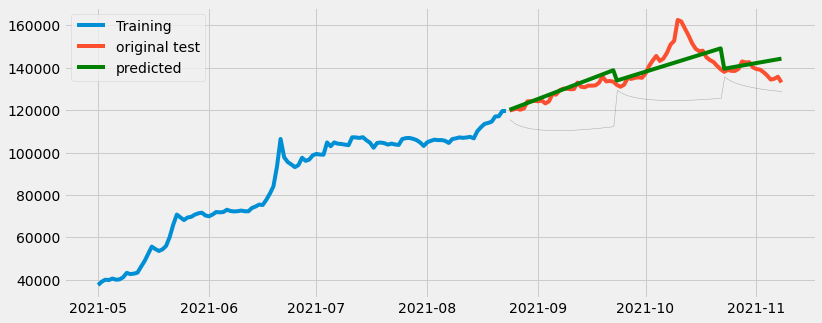

5455.255798671176


In [87]:
model,predictions,rmse_hypertuning=rolling_forecast_arima_final(train,test,order=(1,1,0),seasonal_order=(0,0,0,7),window="sliding",forecast_steps=30,plotting=True)
print(rmse_hypertuning)

In [155]:
model.seasonal_order

(0, 0, 0, 7)

In [157]:
test.index[-1]

Timestamp('2021-11-08 00:00:00')

In [280]:
class predictions_new():
    
    '''
    For reusability
    -Takes data , generates out of sample forecasts for data occuring after the provided date
    -After performing predictions , sets the new timestamp to where predictions stopped 
    '''
    
    def __init__(self,data):
        self.current_time_stamp=data.index[-1]
        self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        self.data=data
        self.predictions_df= pd.Series([])
    
    def forecast(self,model,forecast_steps,plotting=True):
        self.endtimestamp=self.nexttimestamp + timedelta(days = forecast_steps-1)
        out_sample_predictions=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).predicted_mean
        confidence_intervals=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int()
        print("Predicting {} steps ahead".format(forecast_steps))
        if plotting :
            plt.figure(figsize=(12,5))
            plt.plot(self.data,label="insample")
            lower_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
            upper_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()
        
        self.nexttimestamp=self.endtimestamp + timedelta(days = 1)
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
 

#### We want to fit the model to the last observation using the hyper parameters we got 

In [282]:
#fitting the model
model=sm.tsa.statespace.SARIMAX(train.append(test),order=(1,0,0),seasonal_order=(1,1,1,7),trend='c')
model_ARIMA = model.fit()

In [283]:
predict_instance=predictions_new(train.append(test))

Predicting 30 steps ahead


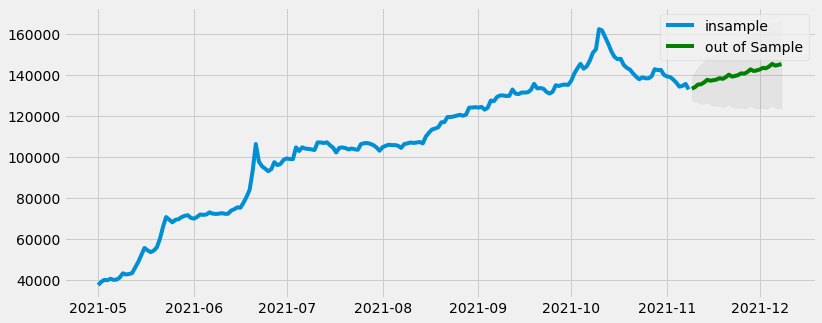

In [284]:
predict_instance.forecast(model_ARIMA,30)

Predicting 30 steps ahead


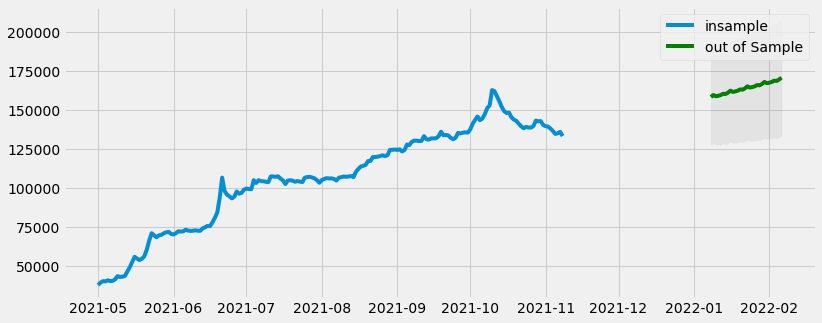

In [286]:
predict_instance.forecast(model_ARIMA,30)

### Generic Class to be used in Pipeline

In [573]:
class predictions:
    
    def __init__(self,data):
        
        #Initially a model and a 
        self.initial_data=data
        self.data=data
        self.incoming=None
        
#         self.current_time_stamp=self.data.index[-1]        
#         self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        self.timestamp_definition(self.data)
        self.model=None
        
        self.predictions_df= pd.Series([])

    def train(self,out_of_sample_size):
        auto_arima_model=auto_arima(self.data[:-1 *out_of_sample_size] ,start_p=0,d=None,start_q=0,
                      max_p=8,max_d=2,max_q=8,
                       start_Q=0,max_Q=8,
                       start_P=0,max_P=8,m=7, max_D=4,D=None,
                       seasonal=True,supress_warnings=True,n_fits=50,out_of_sample_size=out_of_sample_size )
        
        self.model_best_order,self.model_seasonal_order=auto_arima_model.order,auto_arima_model.seasonal_order
        print(f"Order is {self.model_best_order}")
        print(f"Seasonal Order is {self.model_seasonal_order}")

        
        
    def fit(self):
#         model=sm.tsa.statespace.SARIMAX(self.data,order=(1,1,0),seasonal_order=(0,0,0,7),trend='c')
        model=sm.tsa.statespace.SARIMAX(self.data,order=self.model_best_order,seasonal_order=self.model_seasonal_order,trend='c')

        model_ARIMA = model.fit()
        
        self.model=model_ARIMA
        
        self.model_start_timestamp=self.data.index[0] 
        self.model_end_timestamp=self.data.index[-1]
        
    def incoming_new(self,*args):
        
        incoming_series=pd.Series(list(args),pd.date_range(self.nexttimestamp,periods=len(args),freq='D'))
        try :
            self.incoming_all=self.incoming_all.append(incoming_series)
        except :
            self.incoming_all=incoming_series
        
        self.data=self.data.append(incoming_series) 
        self.timestamp_definition(self.data)
        
#         self.current_time_stamp=self.data.index[-1]        
#         self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        
    def reset_incoming(self):
        self.incoming_all=None
        self.data=self.initial_data
        self.timestamp_definition(self.data)
    
    def timestamp_definition(self,data):
        self.current_time_stamp=data.index[-1]        
        self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        
        
   
    def forecast(self,forecast_steps,plotting=False):           
        
        self.endtimestamp=self.nexttimestamp + timedelta(days = forecast_steps-1)      
        
        out_sample_predictions=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).predicted_mean
        confidence_intervals=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int()
        
        lower_series=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
        upper_series=self.model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
        
        '''
        self.nexttimestamp=self.endtimestamp + timedelta(days = 1)
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
        '''
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
    
    
        if plotting:
            plt.figure(figsize=(12,5))
            plt.plot(self.initial_data,label="Original")
            try:
                plt.plot(self.incoming_all,label="incoming")
            except:
                pass
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()
        
       
            

In [751]:
#Generate new instace
continous_predictions=predictions(train.append(test))

In [752]:
continous_predictions.train(30)

Order is (1, 1, 0)
Seasonal Order is (3, 0, 0, 7)


In [753]:
continous_predictions.fit()

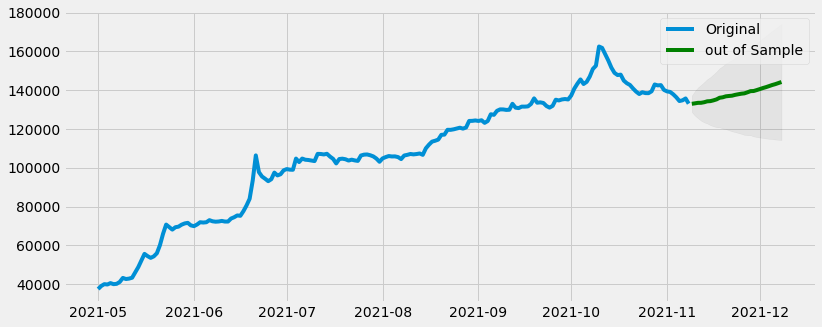

In [754]:
continous_predictions.forecast(30,plotting=True)

In [738]:
#Predict without Fitting 
#Predict with fitting
#Predict with training

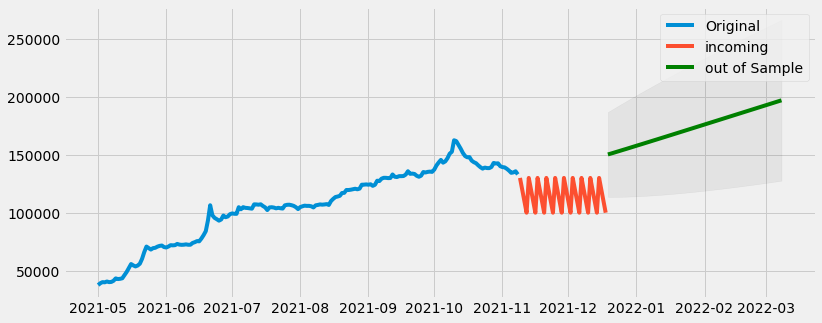

In [764]:
# continous_predictions.reset_incoming()
# continous_predictions.incoming_new(130000,120000,110000,100000,90000,85000,80000,90000,92000,93000,91000,78000)
continous_predictions.incoming_new(130000,120000,110000,100000)
# continous_predictions.incoming_new(125000,140000)

# continous_predictions.train(30)

# continous_predictions.fit()
continous_predictions.forecast(80,plotting=True)

Order is (1, 1, 0)
Seasonal Order is (3, 0, 0, 7)


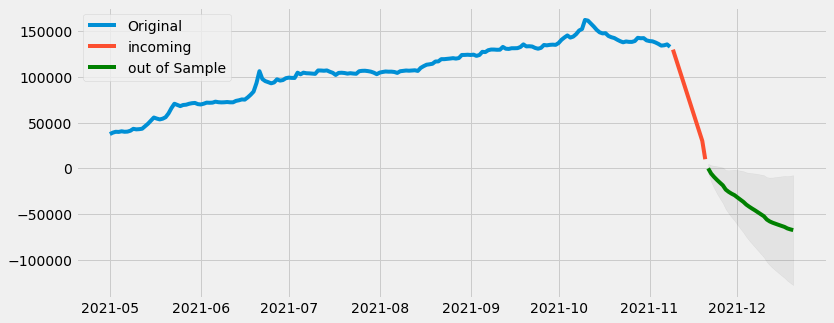

In [732]:
continous_predictions.reset_incoming()
# continous_predictions.incoming_new(125000,140000)
continous_predictions.incoming_new(130000,120000,110000,100000,90000,80000,70000,60000,50000,40000,30000,10000)

continous_predictions.train(40)

continous_predictions.fit()
continous_predictions.forecast(30,plotting=True)

In [ ]:
continous_predictions.reset_incoming()
continous_predictions.incoming_new(130000,120000,110000,100000,90000,85000,80000,90000,92000,93000,91000,78000)

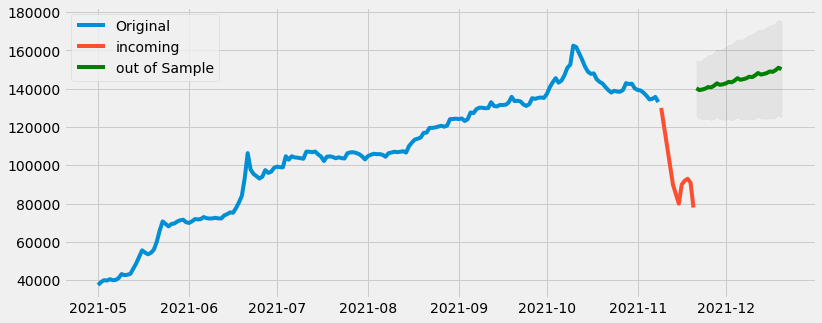

In [455]:
# continous_predictions.forecast(30,plotting=True)

In [543]:
print(continous_predictions.model_start_timestamp)
print(continous_predictions.model_end_timestamp)


2021-05-01 00:00:00
2021-11-16 00:00:00


## Workspace

In [310]:
def add(*args):
    sum=0
    
    for x in args:
        sum=sum + x
    return list(args)

In [311]:
add(4,5,6)

[4, 5, 6]

In [ ]:
class predictions():
    
    '''
    For reusability
    -Takes data , generates out of sample forecasts for data occuring after the provided date
    -After performing predictions , sets the new timestamp to where predictions stopped 
    '''
    
    def __init__(self,trained_data):
        
        self.start_time_stamp=trained_data.index[0]
        self.current_time_stamp=trained_data.index[-1]        
        self.nexttimestamp=self.current_time_stamp + timedelta(days = 1)
        
        self.initial_trained_data=trained_data
        self.trained_data=trained_data
        self.predictions_df= pd.Series([])
    
    def forecast(self,model,forecast_steps,plotting=True):
        
#         self.endtimestamp=self.nexttimestamp + timedelta(days = forecast_steps-1)
        
        out_sample_predictions=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).predicted_mean
        confidence_intervals=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int()
        
        self.model=model
        
        self.model_train_start_timestamp= self.trained_data.index[0]
        self.model_train_end_timestamp=self.trained_data.index[-1]
        
        
        
        print("Predicting {} steps ahead".format(forecast_steps))
        if plotting :
            plt.figure(figsize=(12,5))
            plt.plot(self.data,label="insample")
            lower_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
            upper_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()y
        
        self.nexttimestamp=self.endtimestamp + timedelta(days = 1)
        self.predictions_df=self.predictions_df.append(out_sample_predictions)
        
    
    def incoming(self,*args):
        
        real_series=pd.Series(list(args),pd.date_range(self.current_time_stamp,periods=len(args),freq='D'))
        
        self.data=self.data.append(real_series)    
        
        self.current_time_stamp=self.current_time_stamp + timedelta(days = len(args))
        
    def retrain_based_on_incoming(self,train=yes,plotting=True):
        if train=yes:
            self.model=sm.tsa.statespace.SARIMAX(self.data,order=model.order,seasonal_order=model.seasonal_order,trend=model.trend)
            
        
        if plotting :
            plt.figure(figsize=(12,5))
            plt.plot(self.initial_data,label="Original data")
#             lower_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,0]            
#             upper_series=model.get_prediction(start=self.nexttimestamp,end=self.endtimestamp).conf_int().iloc[:,1]
            plt.plot(out_sample_predictions,color='green',label='out of Sample')
            plt.fill_between(lower_series.index,lower_series.values,upper_series.values,color='k',alpha=0.05)
            plt.legend()
            plt.show()y
        
        
        
    def plotting():
        
        
           

#         return out_sample_predictions,confidence_intervals
    
     


### LSTM